In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "white",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
    "font.size": 25})

%matplotlib inline

In [2]:
dataDir = "../data generation/Tstat/stdin/"
datafile = "/log_tcp_complete"
poolIPsFile = "../poolIP.txt"

In [3]:
## Aggregate Data
raw_df = pd.DataFrame()
for datafolder in sorted(os.listdir(dataDir)):
    dataPointFile = dataDir + datafolder + datafile
    raw_df = pd.concat([raw_df, pd.read_csv(dataPointFile, sep = ' ')])

In [4]:
raw_df = raw_df.reset_index(drop=True)

In [5]:
raw_df

,#09#c_ip:1,c_port:2,c_pkts_all:3,c_rst_cnt:4,c_ack_cnt:5,c_ack_cnt_p:6,c_bytes_uniq:7,c_pkts_data:8,c_bytes_all:9,c_pkts_retx:10,...,s_cwin_ini:95,s_pkts_rto:96,s_pkts_fs:97,s_pkts_reor:98,s_pkts_dup:99,s_pkts_unk:100,s_pkts_fc:101,s_pkts_unrto:102,s_pkts_unfs:103,s_syn_retx:104
0,192.168.0.92,43432,12,0,11,5,2473,5,2473,0,...,1460,0,0,1,0,0,0,0,0,0
1,192.168.0.92,43434,12,0,11,5,2595,5,2595,0,...,1460,0,0,1,0,0,0,0,0,0
2,192.168.0.92,45634,16,0,15,7,2999,7,5292,2,...,2920,0,0,1,0,2,0,0,0,0
3,192.168.0.92,45636,12,0,11,5,2765,5,2765,0,...,4435,0,0,1,0,1,0,0,0,0
4,192.168.0.92,47230,10,0,9,6,675,2,675,0,...,2920,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13150,192.168.0.92,57524,40,1,38,26,2645,11,2645,0,...,392,0,0,0,0,0,0,0,0,0
13151,192.168.0.92,57544,10,1,8,3,1354,4,1354,0,...,392,0,0,0,0,0,0,0,0,0
13152,192.168.0.92,57546,13,1,11,6,1354,4,1354,0,...,1448,0,0,1,0,0,0,0,0,0
13153,192.168.0.92,57548,13,1,11,6,1354,4,1354,0,...,2896,0,0,1,0,0,0,0,0,0


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13155 entries, 0 to 13154
Columns: 104 entries, #09#c_ip:1 to s_syn_retx:104
dtypes: float64(17), int64(85), object(2)
memory usage: 10.4+ MB


In [7]:
f = open(dataDir + poolIPsFile, 'r')
poolIPs = f.read().splitlines()

In [8]:
def is_pool(x):
    return 1 if x in poolIPs else 0

raw_df["s_ip:15"] = raw_df["s_ip:15"].apply(is_pool)

In [9]:
raw_df_prooned = raw_df.drop(["#09#c_ip:1", "c_port:2", "s_port:16", 'c_pkts_ooo:12',
 'c_isint:38', 's_isint:39', 'c_iscrypto:40', 's_iscrypto:41', 'p2p_t:43',
  'c_ttl_min:50', 'c_ttl_max:51', 'c_f1323_opt:59', 'c_tm_opt:60',
   'c_sack_opt:62', 'c_mss:64', 'c_win_0:69', 'c_pkts_reor:75',
    'c_pkts_dup:76', 'c_pkts_fc:78', 'c_pkts_unrto:79',
     'c_pkts_unfs:80', 'c_syn_retx:81', 's_pkts_fc:101',
      's_pkts_unfs:103', 's_syn_retx:104'], axis=1)

In [10]:
train_set, test_set = train_test_split(raw_df_prooned, test_size=0.2, random_state=42)

In [11]:
flow_df = train_set.drop(["s_ip:15"], axis=1)
labels = train_set["s_ip:15"].copy()

In [12]:
test_flow_df = test_set.drop(["s_ip:15"], axis=1)
test_labels = test_set["s_ip:15"].copy()

In [13]:
feature_names = flow_df.columns

In [14]:
standardScaler = StandardScaler()
flow_df = standardScaler.fit_transform(flow_df)

In [15]:
test_flow_df = standardScaler.transform(test_flow_df)

In [16]:
treeClassifier = DecisionTreeClassifier()
flow_pred_labels = cross_val_predict(treeClassifier, flow_df, labels, cv=10)
confusion_matrix(labels, flow_pred_labels)

array([[10327,     7],
       [    3,   187]])

## Cross Validation Result:

In [17]:
print("Precision:", precision_score(labels, flow_pred_labels))
print("Recall:", recall_score(labels, flow_pred_labels))
print("F1:", f1_score(labels, flow_pred_labels))

Precision: 0.9639175257731959
Recall: 0.9842105263157894
F1: 0.9739583333333334


In [18]:
treeClassifier.fit(flow_df, labels)

DecisionTreeClassifier()

In [19]:
test_pred_labels = treeClassifier.predict(test_flow_df)

## Test Results:

In [20]:
print("Test Precision:", precision_score(test_labels, test_pred_labels))
print("Test Recall:", recall_score(test_labels, test_pred_labels))
print("Test F1:", f1_score(test_labels, test_pred_labels))

Test Precision: 1.0
Test Recall: 1.0
Test F1: 1.0


In [21]:
confusion_matrix(test_labels, test_pred_labels)

array([[2595,    0],
       [   0,   36]])

# Random Forest Classifier:

In [22]:
randomforestClassifier = RandomForestClassifier(n_estimators=25)
flow_pred_labels = cross_val_predict(randomforestClassifier, flow_df, labels, cv=10)
confusion_matrix(labels, flow_pred_labels)

array([[10333,     1],
       [    4,   186]])

## Cross Validation Result:

In [23]:
print("Precision:", precision_score(labels, flow_pred_labels))
print("Recall:", recall_score(labels, flow_pred_labels))
print("F1:", f1_score(labels, flow_pred_labels))

Precision: 0.9946524064171123
Recall: 0.9789473684210527
F1: 0.9867374005305041


In [24]:
randomforestClassifier.fit(flow_df, labels)

RandomForestClassifier(n_estimators=25)

In [25]:
test_pred_labels = randomforestClassifier.predict(test_flow_df)

## Test Results:

In [26]:
print("Test Precision:", precision_score(test_labels, test_pred_labels))
print("Test Recall:", recall_score(test_labels, test_pred_labels))
print("Test F1:", f1_score(test_labels, test_pred_labels))

Test Precision: 1.0
Test Recall: 1.0
Test F1: 1.0


In [27]:
confusion_matrix(test_labels, test_pred_labels)

array([[2595,    0],
       [   0,   36]])

In [28]:
importances = randomforestClassifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforestClassifier.estimators_], axis=0)

In [29]:
print(feature_names)

Index(['c_pkts_all:3', 'c_rst_cnt:4', 'c_ack_cnt:5', 'c_ack_cnt_p:6',
       'c_bytes_uniq:7', 'c_pkts_data:8', 'c_bytes_all:9', 'c_pkts_retx:10',
       'c_bytes_retx:11', 'c_syn_cnt:13', 'c_fin_cnt:14', 's_pkts_all:17',
       's_rst_cnt:18', 's_ack_cnt:19', 's_ack_cnt_p:20', 's_bytes_uniq:21',
       's_pkts_data:22', 's_bytes_all:23', 's_pkts_retx:24', 's_bytes_retx:25',
       's_pkts_ooo:26', 's_syn_cnt:27', 's_fin_cnt:28', 'first:29', 'last:30',
       'durat:31', 'c_first:32', 's_first:33', 'c_last:34', 's_last:35',
       'c_first_ack:36', 's_first_ack:37', 'con_t:42', 'http_t:44',
       'c_rtt_avg:45', 'c_rtt_min:46', 'c_rtt_max:47', 'c_rtt_std:48',
       'c_rtt_cnt:49', 's_rtt_avg:52', 's_rtt_min:53', 's_rtt_max:54',
       's_rtt_std:55', 's_rtt_cnt:56', 's_ttl_min:57', 's_ttl_max:58',
       'c_win_scl:61', 'c_sack_cnt:63', 'c_mss_max:65', 'c_mss_min:66',
       'c_win_max:67', 'c_win_min:68', 'c_cwin_max:70', 'c_cwin_min:71',
       'c_cwin_ini:72', 'c_pkts_rto:73', 'c_

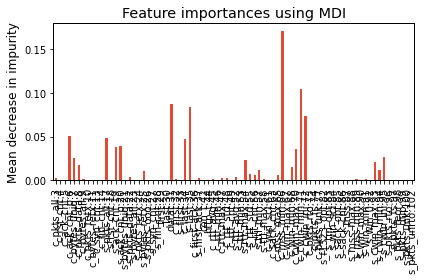

In [30]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Sorted Features by importance

In [33]:
forest_importances.sort_values()[::-1][0:20]

c_mss_min:66       0.170848
c_cwin_min:71      0.104818
durat:31           0.087589
s_last:35          0.083921
c_cwin_ini:72      0.074066
c_ack_cnt_p:6      0.051281
s_pkts_all:17      0.048928
c_last:34          0.047052
s_ack_cnt_p:20     0.038867
s_ack_cnt:19       0.038128
c_cwin_max:70      0.035611
s_cwin_ini:95      0.026651
c_bytes_uniq:7     0.025668
s_rtt_max:54       0.023001
s_cwin_max:93      0.021060
c_pkts_data:8      0.017972
c_win_min:68       0.014844
s_cwin_min:94      0.011619
s_ttl_min:57       0.011445
s_bytes_retx:25    0.010989
dtype: float64

In [34]:
important_features = forest_importances.sort_values()[::-1][0:20].index
print(important_features)

Index(['c_mss_min:66', 'c_cwin_min:71', 'durat:31', 's_last:35',
       'c_cwin_ini:72', 'c_ack_cnt_p:6', 's_pkts_all:17', 'c_last:34',
       's_ack_cnt_p:20', 's_ack_cnt:19', 'c_cwin_max:70', 's_cwin_ini:95',
       'c_bytes_uniq:7', 's_rtt_max:54', 's_cwin_max:93', 'c_pkts_data:8',
       'c_win_min:68', 's_cwin_min:94', 's_ttl_min:57', 's_bytes_retx:25'],
      dtype='object')


In [35]:
simple_flow_df = flow_df[important_features]
simple_test_flow_df = test_flow_df[important_features]

/tmp/ipykernel_39363/434815665.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  simple_flow_df = flow_df[important_features]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices